In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


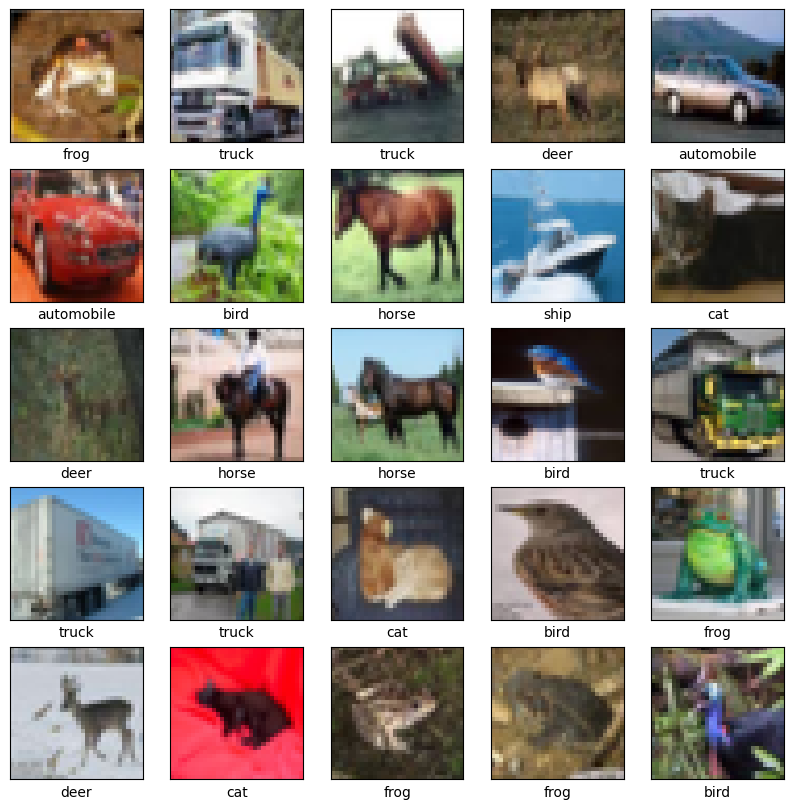

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [6]:
def create_vanilla_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    return model

In [7]:
def create_vggnet():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10))
    return model

In [8]:
def create_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    def res_block(x, filters, kernel_size=3, stride=1):
        y = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(y)
        y = layers.BatchNormalization()(y)

        if stride != 1:
            x = layers.Conv2D(filters, 1, strides=stride, padding='same')(x)

        return layers.add([x, y])

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = res_block(x, 64)
    x = res_block(x, 128, stride=2)
    x = res_block(x, 256, stride=2)
    x = res_block(x, 512, stride=2)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [9]:
def create_lenet():
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(10))
    return model

In [10]:
def create_alexnet():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=1, activation='relu', input_shape=(32, 32, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10))
    return model

In [11]:
def create_densenet():
    growth_rate = 12
    compression_factor = 0.5
    num_dense_blocks = 3

    def dense_block(x, num_layers, growth_rate):
        for _ in range(num_layers):
            y = layers.BatchNormalization()(x)
            y = layers.Activation('relu')(y)
            y = layers.Conv2D(growth_rate, 3, padding='same')(y)
            x = layers.concatenate([x, y])
        return x

    def transition_layer(x, compression_factor):
        num_channels = int(x.shape[-1] * compression_factor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(num_channels, 1, padding='same')(x)
        x = layers.AvgPool2D(2, strides=2, padding='same')(x)
        return x

    inputs = layers.Input(shape=(32, 32, 3))

    x = layers.Conv2D(2 * growth_rate, 3, padding='same', activation='relu')(inputs)

    for _ in range(num_dense_blocks - 1):
        x = dense_block(x, num_layers=12, growth_rate=growth_rate)
        x = transition_layer(x, compression_factor=compression_factor)

    x = dense_block(x, num_layers=12, growth_rate=growth_rate)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [12]:
def compile_and_train(model, train_images, train_labels, test_images, test_labels, epochs=50):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_images, train_labels, epochs=epochs,
                        validation_data=(test_images, test_labels))
    return history

In [13]:
vanilla_cnn = create_vanilla_cnn()
vggnet = create_vggnet()
resnet = create_resnet()
lenet = create_lenet()
alexnet = create_alexnet()
densenet =create_densenet()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
print("Training Vanilla CNN")
history_simple = compile_and_train(vanilla_cnn, train_images, train_labels, test_images, test_labels)

print("Training VGGNet")
history_vgg = compile_and_train(vggnet, train_images, train_labels, test_images, test_labels)

print("Training ResNet")
history_resnet = compile_and_train(resnet, train_images, train_labels, test_images, test_labels)

print("Training LeNet")
history_lenet = compile_and_train(lenet, train_images, train_labels, test_images, test_labels)

print("Training AlexNet")
history_alexnet = compile_and_train(alexnet, train_images, train_labels, test_images, test_labels)

print("Training DenseNet")
history_densenet = compile_and_train(densenet, train_images, train_labels, test_images, test_labels)


Training Vanilla CNN
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3539 - loss: 1.7500 - val_accuracy: 0.5552 - val_loss: 1.2474
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5841 - loss: 1.1888 - val_accuracy: 0.6224 - val_loss: 1.0816
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6461 - loss: 1.0118 - val_accuracy: 0.6718 - val_loss: 0.9563
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6871 - loss: 0.8891 - val_accuracy: 0.6738 - val_loss: 0.9480
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7146 - loss: 0.8162 - val_accuracy: 0.6726 - val_loss: 0.9401
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7352 - loss: 0.7586 - val_accuracy: 0.7028 - val_loss: 0.8695
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7498 - loss: 0.7131 - val_accuracy: 0.7004 - val_loss: 0.8887
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 40ms/step - accuracy: 0.4400 - loss: 1.5252 - val_accuracy: 0.5466 - val_loss: 1.3460
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6749 - loss: 0.9068 - val_accuracy: 0.5802 - val_loss: 1.3316
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.7579 - loss: 0.6924 - val_accuracy: 0.6878 - val_loss: 0.9582
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8065 - loss: 0.5587 - val_accuracy: 0.7189 - val_loss: 0.8189
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8356 - loss: 0.4768 - val_accuracy: 0.7776 - val_loss: 0.6654
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8569 - loss: 0.4103 - val_accuracy: 0.6700 - val_loss: 1.1014
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8771 - loss: 0.3556 - val_accuracy: 0.8110 - val_loss: 0.5615
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8899 - loss: 0.3

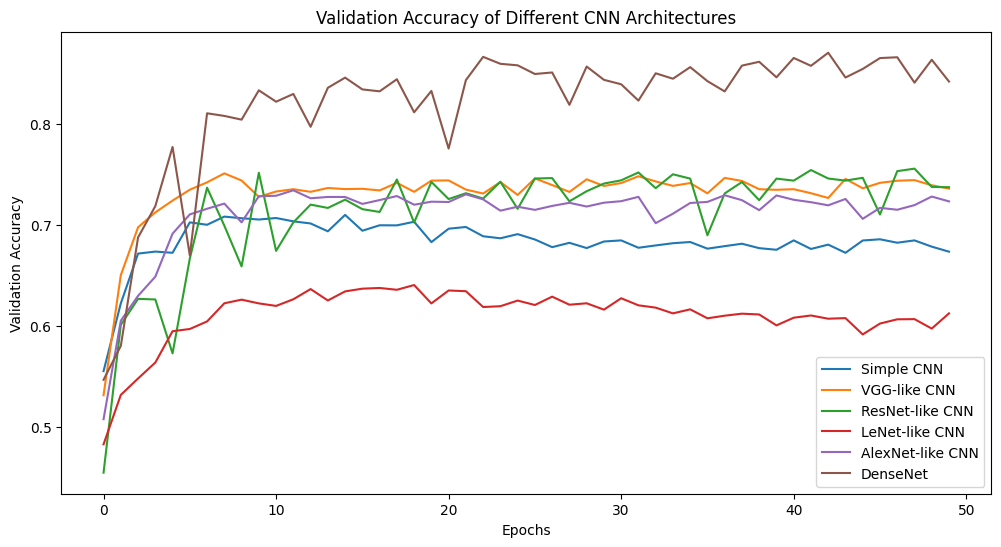

In [15]:
def plot_history(histories, title):
    plt.figure(figsize=(12, 6))
    for name, history in histories:
        plt.plot(history.history['val_accuracy'], label=name)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

plot_history([('Simple CNN', history_simple),
              ('VGG-like CNN', history_vgg),
              ('ResNet-like CNN', history_resnet),
              ('LeNet-like CNN', history_lenet),
              ('AlexNet-like CNN', history_alexnet),
              ('DenseNet', history_densenet)],
             'Validation Accuracy of Different CNN Architectures')